### Preference Data

This notebook takes the raw data obtained from preference data collection in CS-552, performs a little EDA, flattens the fields, and saves it back to memroy so as ready to be loaded by the `PreferenceData` class.

In [13]:
import autorootcwd

%reload_ext autoreload
%autoreload 2

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from datasets import Dataset, DatasetDict, load_from_disk, load_dataset, concatenate_datasets

ROOT = './data'
DATASET_ID = 'preference'
DATA_DIR = f'{ROOT}/{DATASET_ID}'
INPUT_FILE = f'{DATA_DIR}/raw_preference.json'

In [25]:
raw_df = pd.read_json(INPUT_FILE)

# Inspect the data, checking that each question appears once
len(raw_df), raw_df['question_id'].nunique(), raw_df.columns

(1522,
 1522,
 Index(['question_id', 'question_complete', 'course_id', 'preference'], dtype='object'))

In [26]:
raw_df.head()

,question_id,question_complete,course_id,preference
0,0,Question: Consider the following contains func...,15000,[{'A': 'The asymptotic depth of the contains f...
1,3,Question: What is the asymptotic work of <code...,15000,"[{'A': '...', 'B': '...', 'overall': 'A', 'cri..."
2,4,Question: We have a collection of rectangles i...,15000,[{'A': 'Facts: - Rectangles in the plane have ...
3,5,Question: Which of the following scheduler pol...,15005,[{'A': 'Preemptive scheduling policies allow t...
4,7,"Question: In this week's lecture, you have bee...",15000,"[{'A': 'For the computation g(g(1, x1), g(x2, ..."


We notice that each `question_id` contains multiple preferences. Let's see how many

18 preference pairs for first question


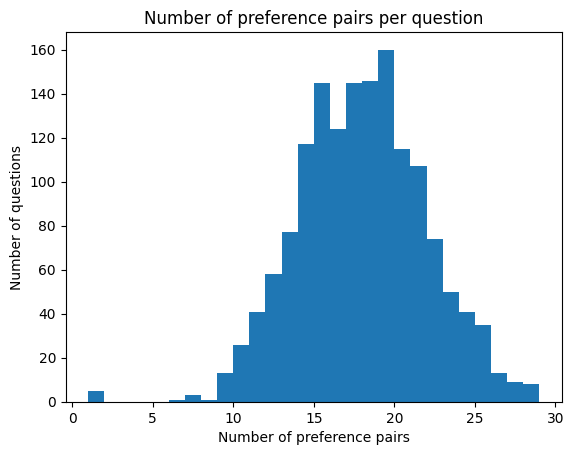

In [27]:
print(len(raw_df['preference'][0]), 'preference pairs for first question')

num_prefs = []
for row in raw_df['preference']:
    num_prefs.append(len(row))

plt.hist(num_prefs, bins=range(1, 30))
plt.xlabel('Number of preference pairs')
plt.ylabel('Number of questions')
plt.title('Number of preference pairs per question')
plt.show()

Let's now make this easier to work with. First, we create a version with all the keys still avaibable, just with the preference pairs flattened.

In [28]:
out_rows = []

for idx, row in raw_df.iterrows():
    preferences = row['preference']
    for pref in preferences:
        out_row = {
            'question_id': row['question_id'],
            'question_complete': row['question_complete'],
            'course_id': row['course_id'],
            'A': pref['A'],
            'B': pref['B'],
            'overall': pref['overall'],
        }
        out_row.update(pref['criteria'])
        out_rows.append(out_row)

df = pd.DataFrame(out_rows)

len(df)

26738

In [29]:
df.head(2)

,question_id,question_complete,course_id,A,B,overall,correctness,relevance,clarity,completeness,other,modified
0,0,Question: Consider the following contains func...,15000,The asymptotic depth of the contains function ...,"When `contains` is called on a List, the `drop...",B,B,B,AB,B,Conciseness: A; Engagement: B,NaN
1,0,Question: Consider the following contains func...,15000,The asymptotic depth of the contains function ...,To determine the asymptotic depth of the `cont...,B,AB,AB,B,B,Conciseness: A; Engagement: AB,NaN


In [30]:
# To HF Dataset
dataset = Dataset.from_pandas(df)
train, val = dataset.train_test_split(test_size=0.2).values()

collection = DatasetDict({
    'train': train,
    'val': val
})

collection.save_to_disk(DATA_DIR)

Saving the dataset (1/1 shards): 100%|██████████| 5348/5348 [00:00<00:00, 42225.31 examples/s]


We now need to convert this to the expected format of a list of dicts with 3 keys:

```
[
    {'prompt': ..., 'chosen': ..., 'rejected': ...},
    { ... }
]
```

## Filtering

Let's explore some filtering options:
- Take the first preference pair for each question
- Take the preference pairs with most or least agreement (most certain) either:
    - on a per question basis, take the maximally agreeing questions
    - on a global score basis

In [49]:
def load_whole_dataset() -> pd.DataFrame:
    hf_dict = DatasetDict.load_from_disk(DATA_DIR)
    hf_dataset = concatenate_datasets([hf_dict['train'], hf_dict['val']])
    return hf_dataset.to_pandas()

df = load_whole_dataset()

### Agreement Metric

Let's investigate this agreement metric

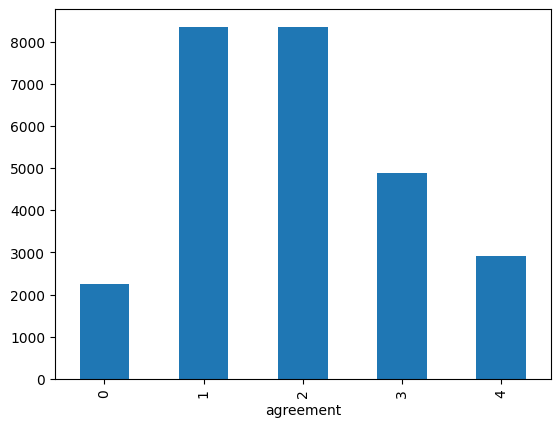

In [44]:
agreement = df.copy(deep=True)
choice = agreement['overall']
agreement['agreement'] = (agreement["correctness"] == choice).astype(int) + (agreement["relevance"] == choice).astype(int) + (agreement["clarity"] == choice).astype(int) + (agreement["completeness"] == choice).astype(int)

# Plot bar chart of agreement
agreement['agreement'].value_counts().sort_index().plot(kind='bar')
plt.show()

In [45]:
# Define filter for global agreement
def global_agreement(row, score=2):
    return row['agreement'] >= score

def global_disagreement(row, score=2):
    return row['agreement'] <= score

# Define filter for higher and lowest agreement on a per question basis
def get_highest_agreement(group, tolerance=1):
    choice = group['overall'] # The overall best

    # Add 1 for each column in agreement with the overall choice
    group['agreement'] = (group['correctness'] == choice).astype(int) + (group['relevance'] == choice).astype(int) + (group['clarity'] == choice).astype(int) + (group['completeness'] == choice).astype(int)

    # Return only those with the max agreement with tolerance
    max_agreement = group['agreement'].max()
    return group[group['agreement'] >= max_agreement - tolerance]

def topk(group, k=3):
    choice = group['overall'] # The overall best

    # Add 1 for each column in agreement with the overall choice
    group['agreement'] = (group['correctness'] == choice).astype(int) + (group['relevance'] == choice).astype(int) + (group['clarity'] == choice).astype(int) + (group['completeness'] == choice).astype(int)

    return group.nlargest(k, 'agreement', keep='all')

def bottomk(group, k=3):
    choice = group['overall'] # The overall best

    # Add 1 for each column in agreement with the overall choice
    group['agreement'] = (group['correctness'] == choice).astype(int) + (group['relevance'] == choice).astype(int) + (group['clarity'] == choice).astype(int) + (group['completeness'] == choice).astype(int)

    return group.nsmallest(k, 'agreement', keep='all')

def get_lowest_agreement(group, tolerance=1):
    choice = group['overall'] # The overall best

    # Add 1 for each column in agreement with the overall choice
    group['agreement'] = (group['correctness'] == choice).astype(int) + (group['relevance'] == choice).astype(int) + (group['clarity'] == choice).astype(int) + (group['completeness'] == choice).astype(int)

    # Return only those with the max agreement with tolerance
    min_agreement = group['agreement'].min()
    return group[group['agreement'] <= min_agreement + tolerance]

### Summary of Filtering Lengths

In [46]:
print('One per question')
print(len(df.groupby('question_id').first().reset_index()))

print('Agreement >= 2')
filtered_certain = df.groupby('question_id').apply(get_highest_agreement, include_groups=False)
print(len(filtered_certain))

print('Agreement <= 2')
filtered_uncertain = df.groupby('question_id').apply(get_lowest_agreement, include_groups=False)
print(len(filtered_uncertain))

print('Per question max, tolerance=1')
filtered_certain = df.groupby('question_id').apply(get_highest_agreement, tolerance=1, include_groups=False)
print(len(filtered_certain))

print('Per question min, tolerance=1')
filtered_uncertain = df.groupby('question_id').apply(get_lowest_agreement, tolerance=1, include_groups=False)
print(len(filtered_uncertain))

print('Top 3 per question + ties')
filtered_certain = df.groupby('question_id').apply(topk, include_groups=False)
print(len(filtered_certain))

print('Bottom 3 per question + ties')
filtered_uncertain = df.groupby('question_id').apply(bottomk, include_groups=False)
print(len(filtered_uncertain))


One per question
1522
Agreement >= 2
9334
Agreement <= 2
12715
Per question max, tolerance=1
9334
Per question min, tolerance=1
12715
Top 3 per question + ties
7435
Bottom 3 per question + ties
9139


### Length Analysis

In [50]:
df = load_whole_dataset()

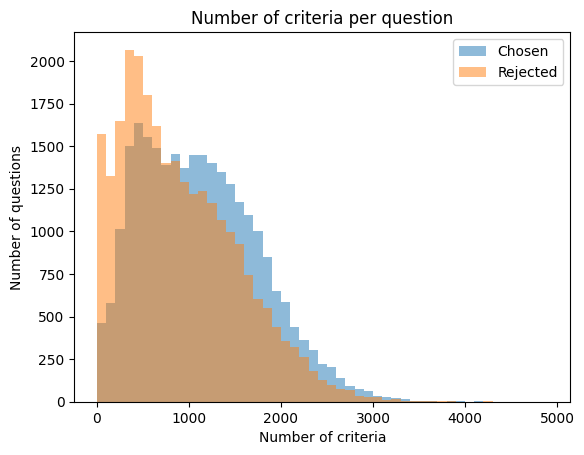

Chosen: 1121.1228588525694
Rejected: 908.0270401675518


In [60]:
lengths_chosen = []
lengths_rejected = []

for idx, row in df.iterrows():
    chosen = row['overall']
    rejected = 'A' if chosen == 'B' else 'B'
    lengths_chosen.append(len(row[chosen]))
    lengths_rejected.append(len(row[rejected]))

plt.hist(lengths_chosen, bins = range(0, 5000, 100), alpha=0.5, label='Chosen')
plt.hist(lengths_rejected, bins=range(0, 5000, 100), alpha=0.5, label='Rejected')
plt.xlabel('Number of criteria')
plt.ylabel('Number of questions')
plt.title('Number of criteria per question')
plt.legend()
plt.show()

# Print mean lengths
print('Chosen:', sum(lengths_chosen) / len(lengths_chosen))
print('Rejected:', sum(lengths_rejected) / len(lengths_rejected))


### Save as JSON

In [ ]:
splits = ["train", "val"]
for split in splits:
    dataset = load_from_disk(DATA_DIR)[split]
    save_path = os.path.join(DATA_DIR, f"{split}.jsonl")
    dataset.to_json(path_or_buf=save_path, orient='records', lines=True)

In [ ]:
# OLD CODE that outputs to 'prompt', 'chosen', 'rejected' format

# df = Dataset.load_from_disk(DATA_DIR)
# df = df.to_pandas()

# out_rows = []

# for idx, row in df.iterrows():
#     prompt = row['question_complete']
#     if row['overall'] == 'A':
#         chosen = row['A']
#         rejected = row['B']
#     elif row['overall'] == 'B':
#         chosen = row['B']
#         rejected = row['A']
#     else:
#         raise ValueError('Invalid overall preference: ', prompt['overall'])
    
#     out_row = {
#         'prompt': prompt,
#         'chosen': chosen,
#         'rejected': rejected,
#     }

#     out_rows.append(out_row)

# out_df = pd.DataFrame(out_rows)

# out_df.head()